# Summary

Tbd

## The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 10


# Camera Calibration

For the camera calibration code from the [opencv camera calibration example](https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html) was adapted.

## Calibration Functions

In [2]:
def get_camera_calibration(image_paths, columns, rows, verbose = False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((columns * rows,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list of calibration images and search for chessboard corners
    file_counter = 0
    chessboard_counter = 0

    for fname in image_paths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        file_counter += 1
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (columns, rows),None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            chessboard_counter += 1
            
    if verbose:
        print("found {} chessboards in {} images.".format(chessboard_counter, file_counter))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist


In [3]:
def undistort(img, calibration_values):
    mtx = calibration_values[0]
    dist = calibration_values[1]
    return cv2.undistort(img, mtx, dist, None, mtx)


## Project Camera Calibration

In [4]:
chessboard_images = glob.glob('./camera_cal/calibration*.jpg')

calibration_values = get_camera_calibration(chessboard_images, 9, 6, True)

found 17 chessboards in 20 images.


## Project Camera Undistort Examples

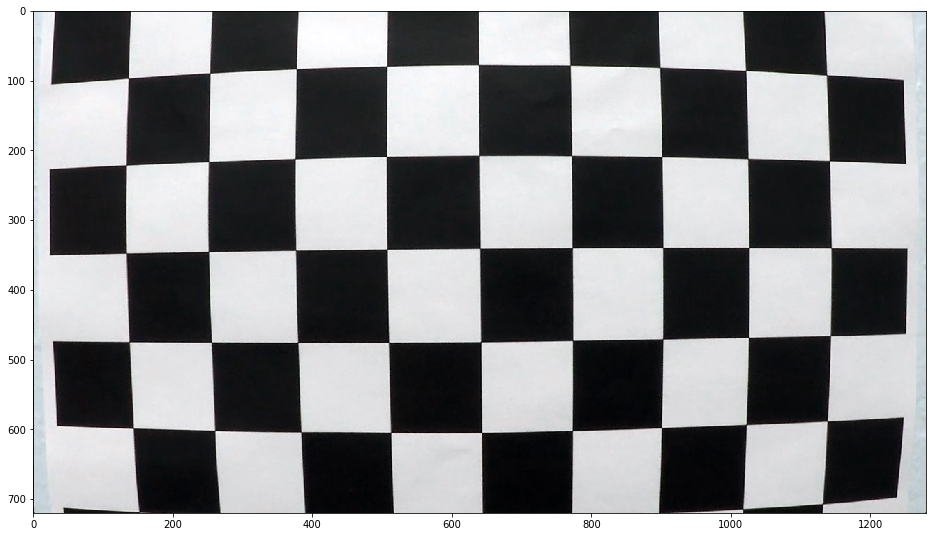

In [5]:
image = cv2.imread(chessboard_images[0])
plt.imshow(image)

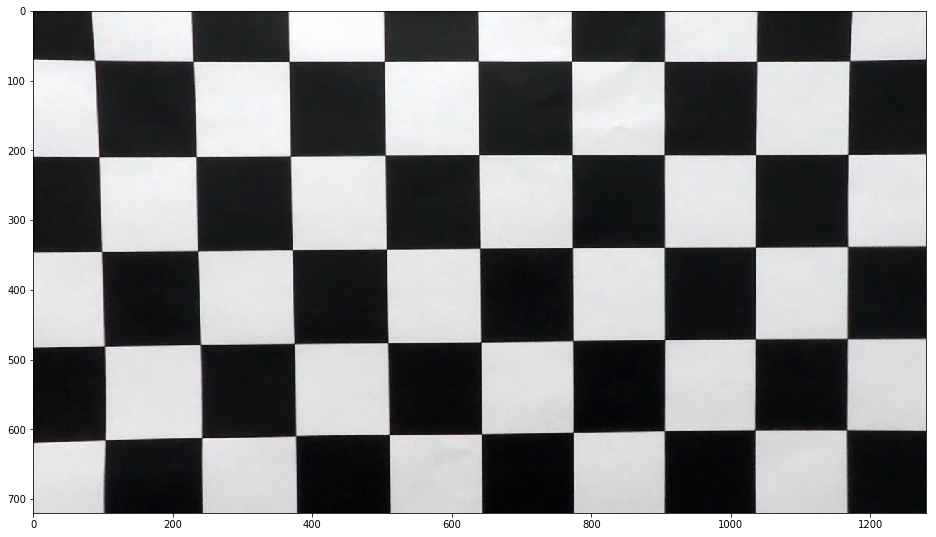

In [6]:
undistorted_image = undistort(image, calibration_values)
plt.imshow(undistorted_image)

## Gopro Calibration

I made my own videos and calibrations images with a gapro session hero 4.

In [7]:
gopro_images = glob.glob('./gopro_cal/*.png')

gopro_calibration_values = get_camera_calibration(gopro_images, 9, 6, True)

found 20 chessboards in 20 images.


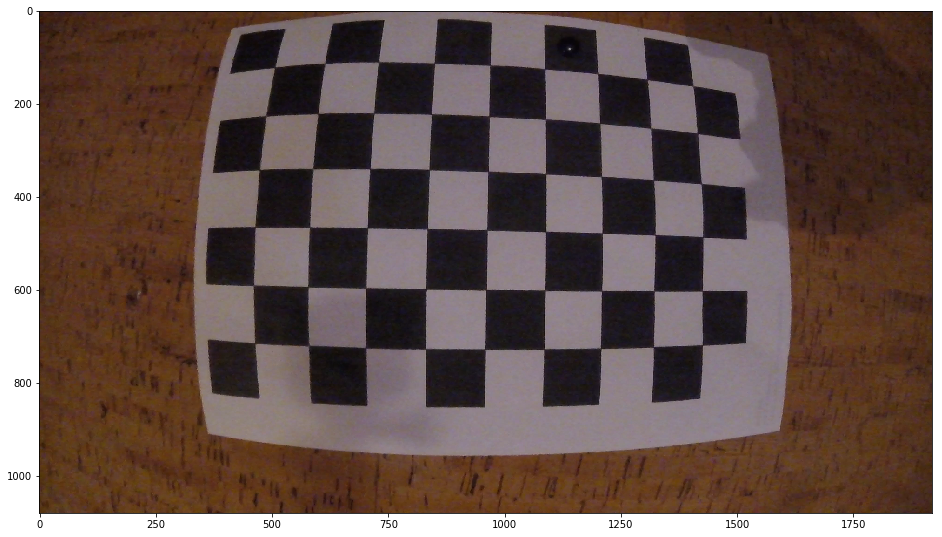

In [8]:
image = cv2.cvtColor(cv2.imread(gopro_images[18]), cv2.COLOR_BGR2RGB)
plt.imshow(image)

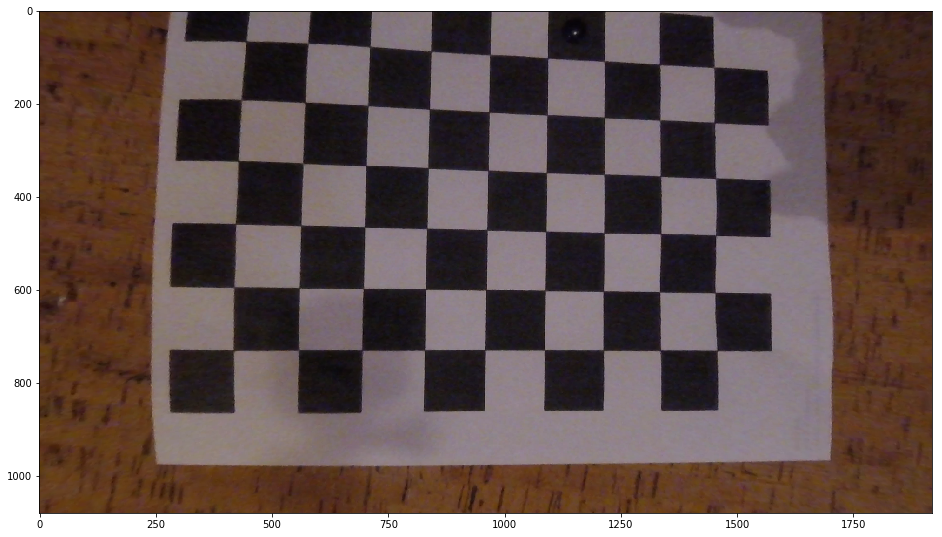

In [9]:
undistorted_image = undistort(image, gopro_calibration_values)
plt.imshow(undistorted_image)

## Undistort Test Images

Load and undistort images.

In [10]:
test_image_paths = glob.glob('./test_images/*.jpg')

test_images = []
undistorted_test_images = []

for image_path in test_image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
    undistorted_test_images.append(undistort(image, calibration_values))

### Original Image Example

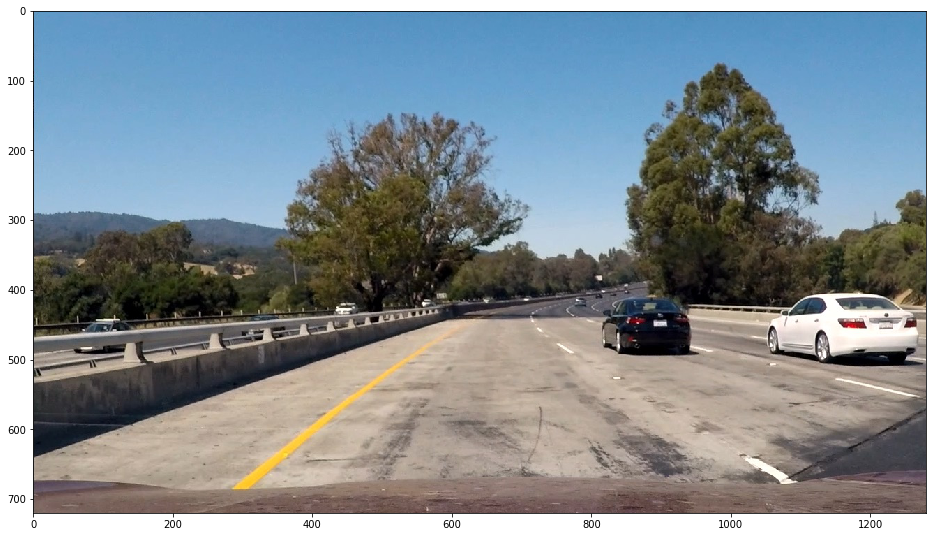

In [11]:
plt.imshow(test_images[2])

### Undistorted Image Example

The difference is hard to see. Most notetable is the car on the right which appears to be nearer to the edge due to the undistortion.

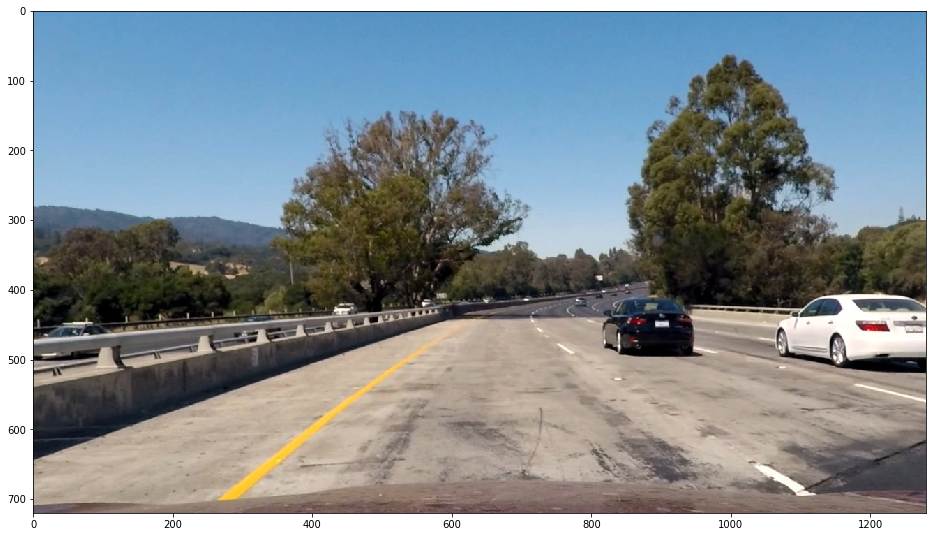

In [12]:
plt.imshow(undistorted_test_images[2])

# Image Filters

Here are the functions developed in the course to create a binary output of an image from which you could detect lane lines.

In [13]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else: 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

In [14]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # Rescale to 8 bit
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

In [15]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [16]:
def hls_select(image, channel = 0, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,channel]
    # 2) Apply a threshold to the S channel
    binary_output =  np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1
    return binary_output

In [17]:
def hls_multi_select(image, thresh=(100, 100, 100)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output =  np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(h_channel < thresh[0]) & (s_channel > thresh[1]) & (l_channel > thresh[2])] = 1
    return binary_output

## Visualization

Here you can use interactive sliders to find good thresholds to detect lane lines.

In [18]:
def show_abs_sobel(image_nr, orient, sobel_kernel, minthresh, maxthresh):
    plt.imshow(abs_sobel_thresh(undistorted_test_images[image_nr], orient = orient, sobel_kernel=sobel_kernel,
                                thresh= (minthresh, maxthresh)), cmap="gray")
def show_dir_sobel(image_nr, sobel_kernel, minthresh, maxthresh):
    plt.imshow(dir_threshold(undistorted_test_images[image_nr], sobel_kernel=sobel_kernel, thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_mag_sobel(image_nr, sobel_kernel, minthresh, maxthresh):
    plt.imshow(mag_thresh(undistorted_test_images[image_nr], sobel_kernel=sobel_kernel, mag_thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_hls_select(image_nr, channel, minthresh, maxthresh):
    plt.imshow(hls_select(undistorted_test_images[image_nr], channel=channel, thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_hls_multi_select(image_nr, h_thresh, s_thresh, l_thresh):
    plt.imshow(hls_multi_select(undistorted_test_images[image_nr], thresh=(h_thresh, s_thresh, l_thresh)), cmap="gray")

<function __main__.show_abs_sobel>

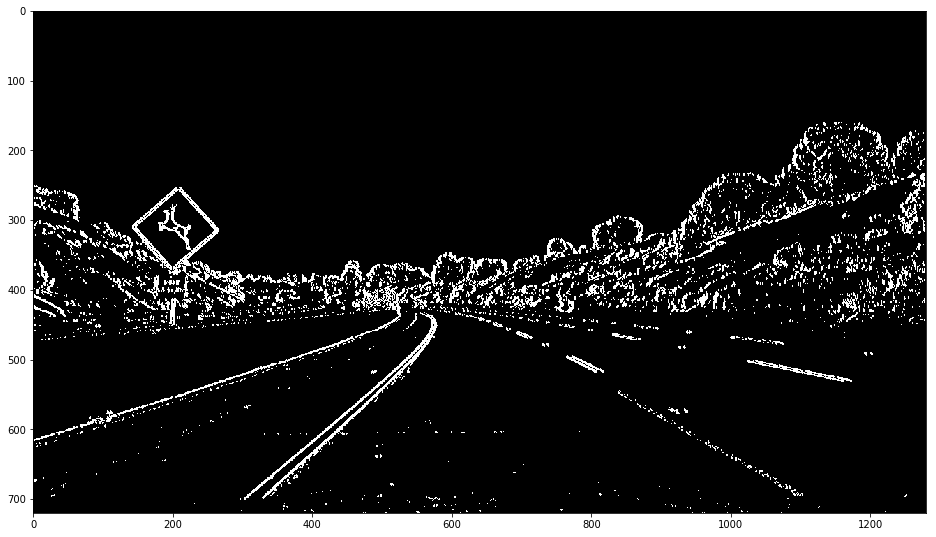

In [19]:
interact(show_abs_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         orient = ["x", "y"],
         sobel_kernel=widgets.IntSlider(min=1,max=31,step=2,value=3),
         minthresh=widgets.IntSlider(min=0,max=255,step=1,value=20),
         maxthresh=widgets.IntSlider(min=0,max=255,step=1,value=255))


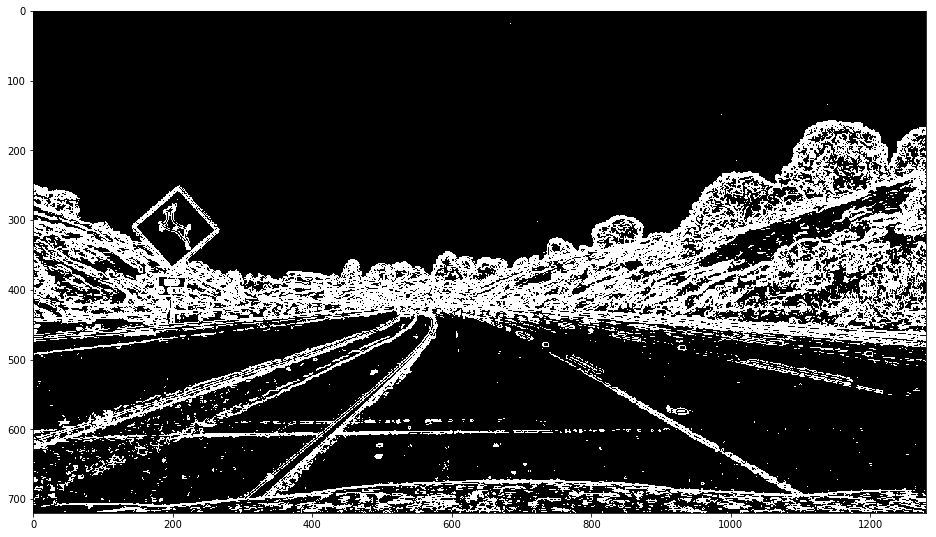

In [20]:
interact(show_mag_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         sobel_kernel=widgets.IntSlider(min=0,max=20,step=1,value=3),
         minthresh=widgets.IntSlider(min=0,max=255,step=1,value=10),
         maxthresh=widgets.IntSlider(min=0,max=255,step=1,value=100));


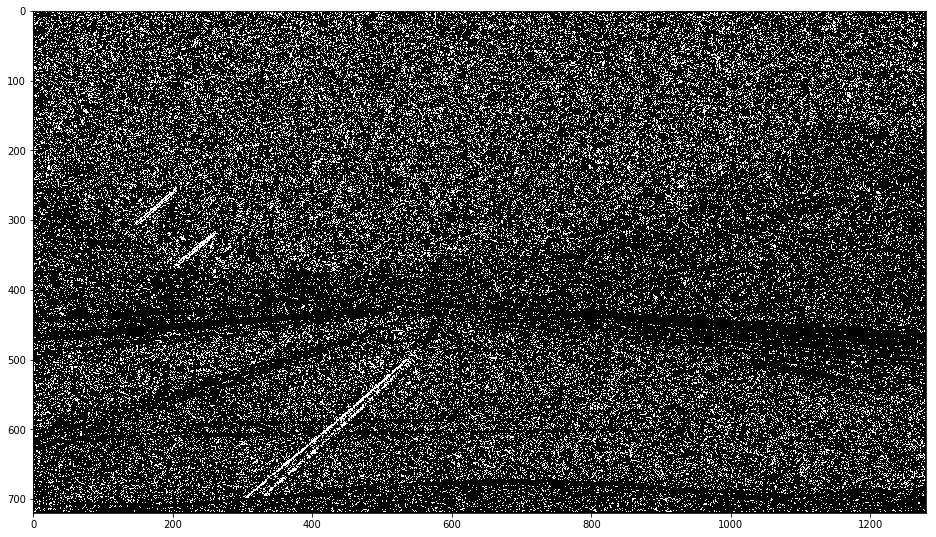

In [21]:
interact(show_dir_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         sobel_kernel=widgets.IntSlider(min=1,max=31,step=2,value=3),
         minthresh=widgets.FloatSlider(min=0.0,max=np.pi/2,step=0.01,value=0.78),
         maxthresh=widgets.FloatSlider(min=0.0,max=np.pi/2,step=0.01,value=0.97));


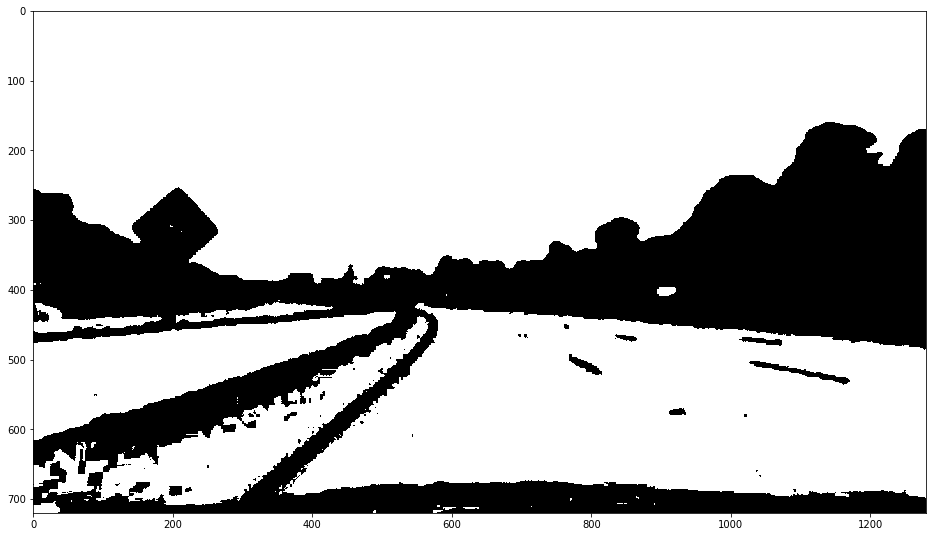

In [22]:
interact(show_hls_select, 
         image_nr = [0, len(undistorted_test_images) - 1],
         channel = {"h": 0, "l": 1, "s": 2},
         minthresh=widgets.IntSlider(min=0,max=359,step=1,value=77),
         maxthresh=widgets.IntSlider(min=0,max=359,step=1,value=359));


<function __main__.show_hls_multi_select>

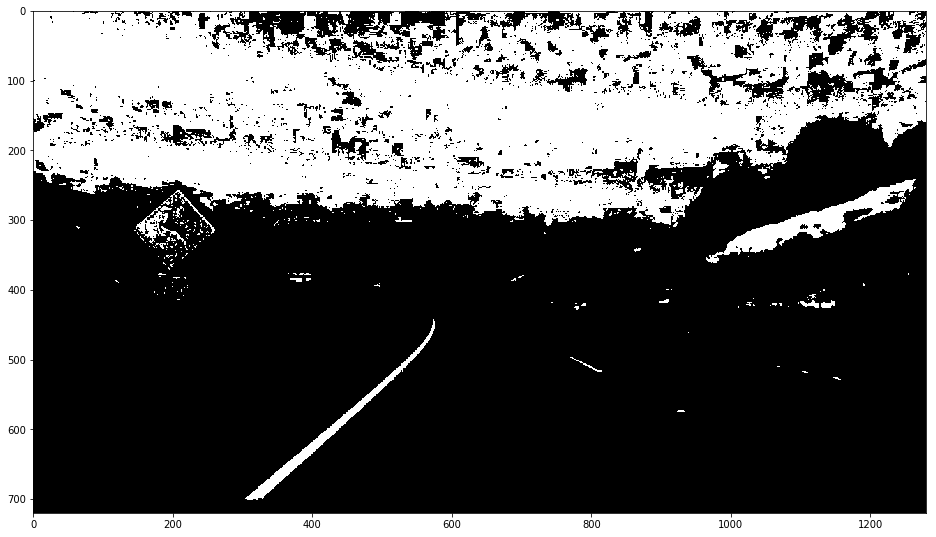

In [23]:
interact(show_hls_multi_select, 
         image_nr = [0, len(undistorted_test_images) - 1],
         h_thresh=widgets.IntSlider(min=0,max=359,step=1,value=195),
         l_thresh=widgets.IntSlider(min=0,max=359,step=1,value=115),
         s_thresh=widgets.IntSlider(min=0,max=359,step=1,value=100))


## Filter Combinations

It seems like the absolute sobel filter in x direction and the saturation of the hls colorspace are very promising.

In [24]:
def absolute_x_and_s(image, abs_min_tresh = 15, s_min_thresh = 110):
    abs_img = abs_sobel_thresh(image, orient="x", thresh = (abs_min_tresh, 255))
    s_img = hls_select(image, channel=2, thresh=(s_min_thresh, 360))
    combined_binary =  np.zeros_like(abs_img)
    # 3) Return a binary image of threshold result
    combined_binary[(abs_img == 1) | (s_img == 1)] = 1
    return combined_binary

In [25]:
def show_absolute_x_and_s(image_nr, abs_min_tresh, s_min_thresh):
    plt.imshow(absolute_x_and_s(undistorted_test_images[image_nr], abs_min_tresh, s_min_thresh), cmap="gray")

<function __main__.show_absolute_x_and_s>

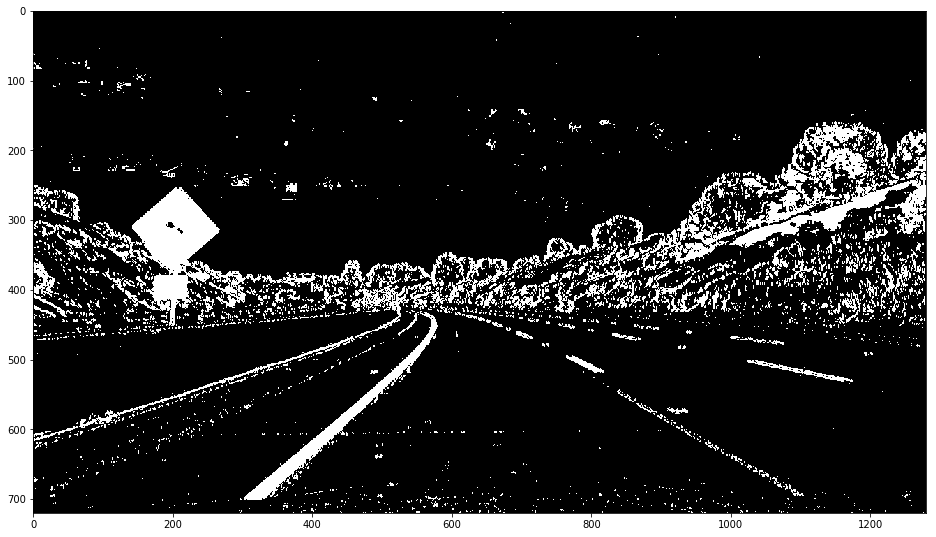

In [26]:
interact(show_absolute_x_and_s, 
         image_nr = [0, len(undistorted_test_images) - 1],
         abs_min_tresh=widgets.IntSlider(min=0,max=255,step=1,value=15),
         s_min_thresh=widgets.IntSlider(min=0,max=359,step=1,value=110))


# Perspective Transform

## Region to transform

In [27]:
def get_region_of_interest_vertices(img, x_shift_from_middle_percent = 4.4, y_shift_from_middle_percent = 12.0):
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    bottom_left = (0, img_height)
    bottom_right = (img_width, img_height)
    
    x_shift_from_middle = img_width * (x_shift_from_middle_percent / 100)
    y_shift_from_middle = img_height * (y_shift_from_middle_percent / 100)

    
    middle_left = (round((img_width / 2) - x_shift_from_middle), round((img_height / 2) + y_shift_from_middle))
    middle_right = (round((img_width / 2) + x_shift_from_middle), round((img_height / 2) + y_shift_from_middle))
        
    return np.array([[bottom_left, middle_left, middle_right, bottom_right]], dtype=np.int32)


def draw_region_of_interest(img, vertices):
    work_on_img = np.copy(img)
    result = cv2.polylines(work_on_img, vertices, isClosed = True, thickness = 3, color = (255,0,0))
    return result

## Intuitively picked region

I picked the region on intuition. As you can see, it is not a good choice.

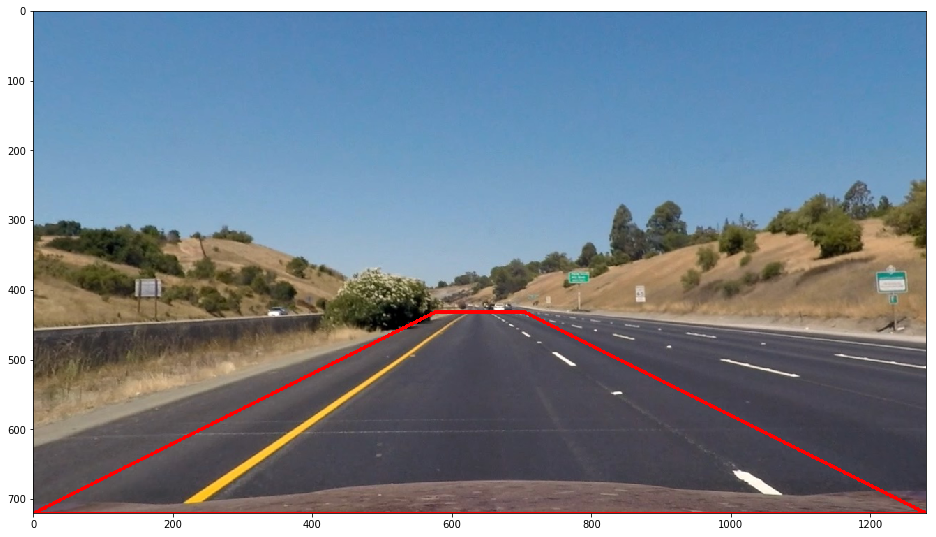

In [28]:
verts = get_region_of_interest_vertices(undistorted_test_images[0], 5, 10)
plt.imshow(draw_region_of_interest(undistorted_test_images[0], verts))

In [29]:
verts

array([[[   0,  720],
        [ 576,  432],
        [ 704,  432],
        [1280,  720]]], dtype=int32)

In [30]:
def perspective_transform(image, vertices):

    width = image.shape[1]
    height = image.shape[0]

    selected_points = np.float32(vertices)
    target_points = np.float32([[0, height], [0, 0], [width, 0], [width, height]])

    transform = cv2.getPerspectiveTransform(selected_points, target_points)
    warped = cv2.warpPerspective(image, transform, (width, height), flags=cv2.INTER_LINEAR)
    return warped

In [31]:
warped = perspective_transform(undistorted_test_images[0], verts)

In the following image, i would expect straight lines. But the transformation vertices are not picked very well.

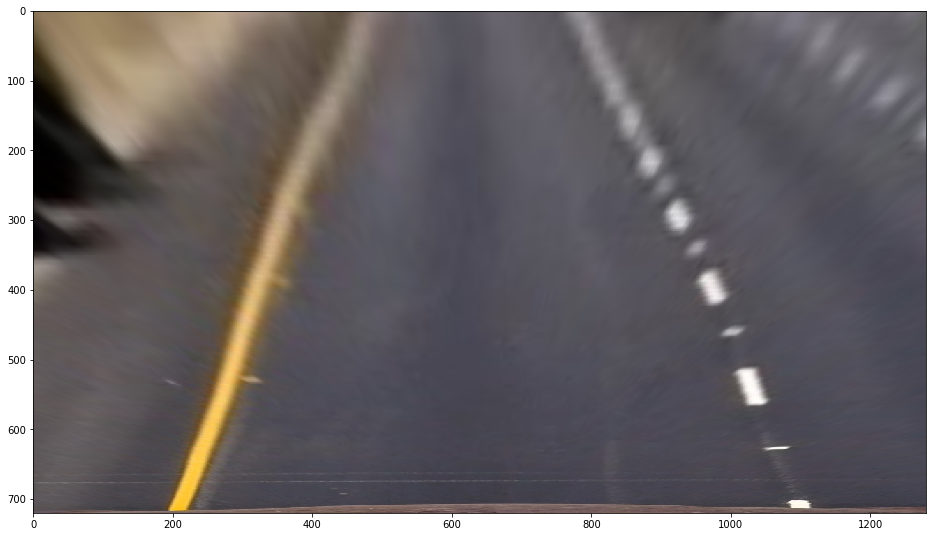

In [32]:
plt.imshow(warped)

## Visually picking transform values.

Therfore I will use interactive sliders to visually pick good values. If you run the notebook you can see sliders to select the the placement of the transform vertices. You wont see these in the html version. When these sliders are moved, the images are updated to show the new rectangle and warped image.

In [33]:
def show_warp(image_nr, x_deviation, y_deviation):
    verts = get_region_of_interest_vertices(undistorted_test_images[image_nr], x_deviation, y_deviation)
    warped = perspective_transform(undistorted_test_images[image_nr], verts)

    plt.subplot(1,2,1)
    plt.imshow(draw_region_of_interest(undistorted_test_images[image_nr], verts))

    plt.subplot(1,2,2)
    plt.imshow(warped)

<function __main__.show_warp>

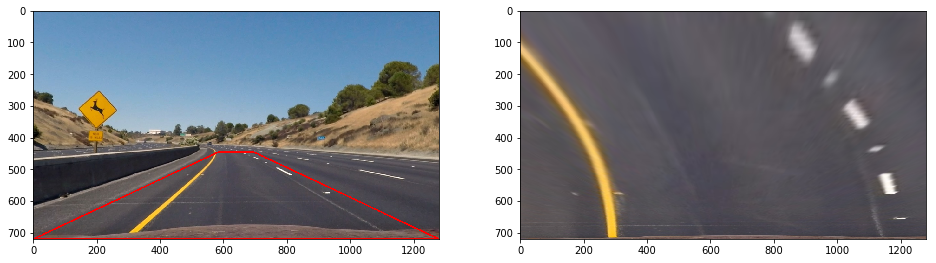

In [34]:
interact(show_warp,
         image_nr = [0, len(undistorted_test_images) - 1],
        x_deviation=widgets.FloatSlider(min=0.0,max=20.0,step=0.01,value=4.4),
        y_deviation=widgets.FloatSlider(min=0.0,max=20.0,step=0.1,value=12.0))

So good values for the perspective transformation are a x deviation of 4.4% and a y deviation of 12%. 

In [35]:
verts = get_region_of_interest_vertices(undistorted_test_images[0], 4.4, 12.0)

# Filter and warp Combination

In [36]:
def show_filter_and_warp(image_nr):
    verts = get_region_of_interest_vertices(undistorted_test_images[image_nr])
    warped = perspective_transform(undistorted_test_images[image_nr], verts)
    
    filtered = absolute_x_and_s(undistorted_test_images[image_nr])
    filtered_warped = perspective_transform(filtered, verts)

    plt.subplot(2,2,1)
    plt.imshow(draw_region_of_interest(undistorted_test_images[image_nr], verts))

    plt.subplot(2,2,2)
    plt.imshow(warped)
    
    plt.subplot(2,2,3)
    plt.imshow(filtered, cmap="gray")
    
    plt.subplot(2,2,4)
    plt.imshow(filtered_warped, cmap="gray")

<function __main__.show_filter_and_warp>

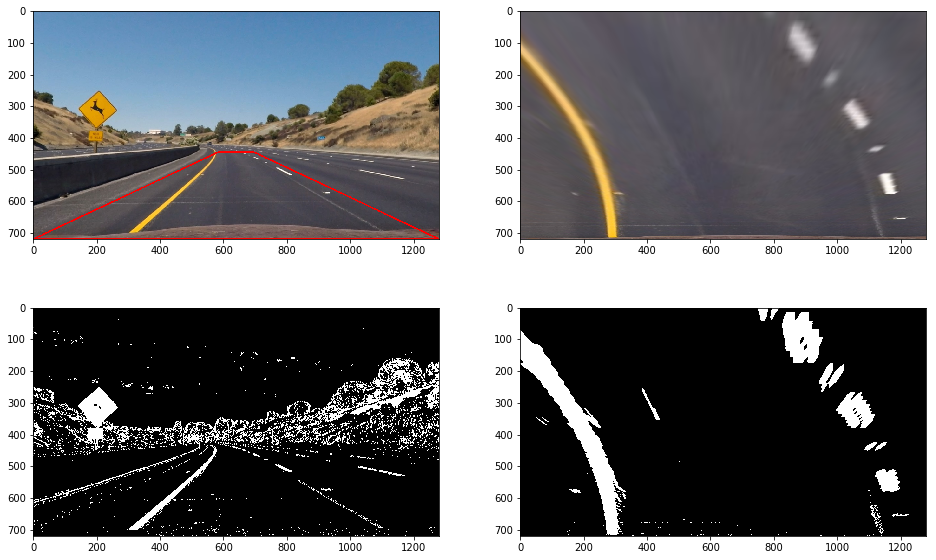

In [37]:
interact(show_filter_and_warp, image_nr = [0, len(undistorted_test_images) - 1])